In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv('009A_ARB015.csv')
df['date'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('date', inplace=True)
df = df[0:-100]
df.head()

,Unnamed: 0,Value
date,,
2021-04-05 17:02:00+00:00,2021-04-05 17:02:00+00:00,296.0
2021-04-05 17:12:00+00:00,2021-04-05 17:12:00+00:00,320.0
2021-04-05 17:22:00+00:00,2021-04-05 17:22:00+00:00,327.0
2021-04-05 17:32:00+00:00,2021-04-05 17:32:00+00:00,320.0
2021-04-05 17:42:00+00:00,2021-04-05 17:42:00+00:00,310.0


In [4]:
def take_derivative(df, smooth_window='8h', sensitivity=1e-5):
    df = df.copy()
    df['smoothed'] = df['Value'].rolling(window=smooth_window, min_periods=1, center=True).mean()
    df['time diff'] = df.index.to_series().diff(periods=1).dt.seconds
    df['mean diff'] = df['smoothed'].diff(1).fillna(0) / df.index.to_series().diff(periods=1).dt.seconds 
    df = df.drop(df[df['mean diff'] < -1e100]['mean diff'].index)
    
    df_down = df[df['mean diff'] < -1*sensitivity]
    df_up = df[df['mean diff'] >= sensitivity]
    
    return df, df_down, df_up

In [5]:
df, df_down, df_up = take_derivative(df)

In [6]:
df.head()

,Unnamed: 0,Value,smoothed,time diff,mean diff
date,,,,,
2021-04-05 17:02:00+00:00,2021-04-05 17:02:00+00:00,296.0,301.800000,NaN,NaN
2021-04-05 17:12:00+00:00,2021-04-05 17:12:00+00:00,320.0,302.269231,600.0,0.000782
2021-04-05 17:22:00+00:00,2021-04-05 17:22:00+00:00,327.0,302.777778,600.0,0.000848
2021-04-05 17:32:00+00:00,2021-04-05 17:32:00+00:00,320.0,303.071429,600.0,0.000489
2021-04-05 17:42:00+00:00,2021-04-05 17:42:00+00:00,310.0,303.310345,600.0,0.000398


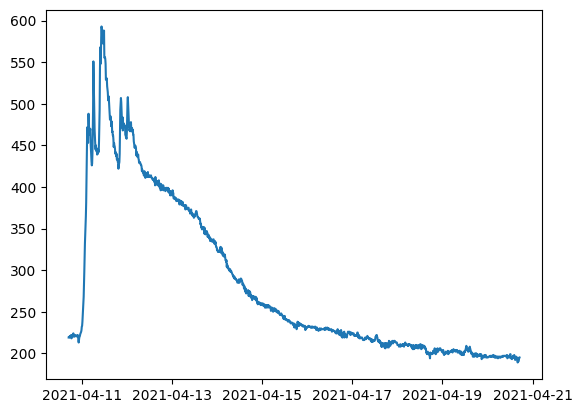

In [7]:
subset = df["2021-04-10 17:02:00+00:00": "2021-04-20 17:02:00+00:00"]
plt.plot(subset.index, subset['Value'])

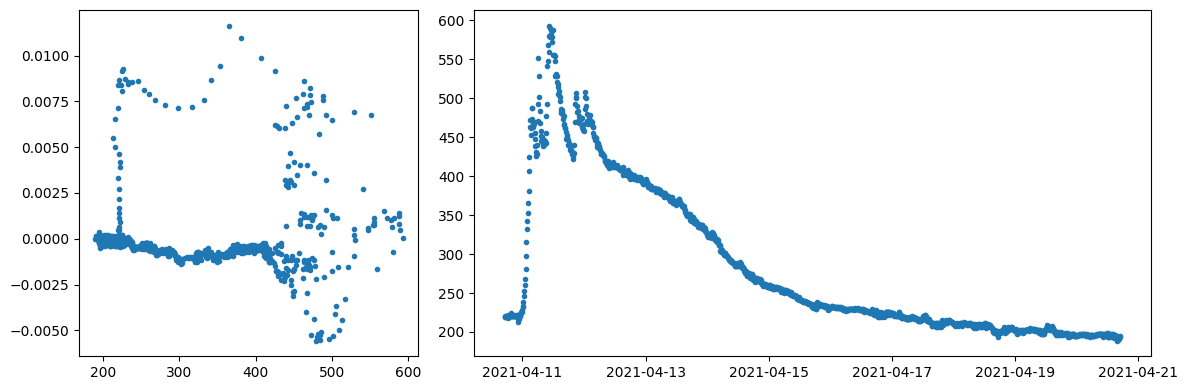

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2]})
ax[0].scatter(subset['Value'], subset['mean diff'], marker='.')
ax[1].scatter(subset.index, subset['Value'], marker='.')
plt.tight_layout()

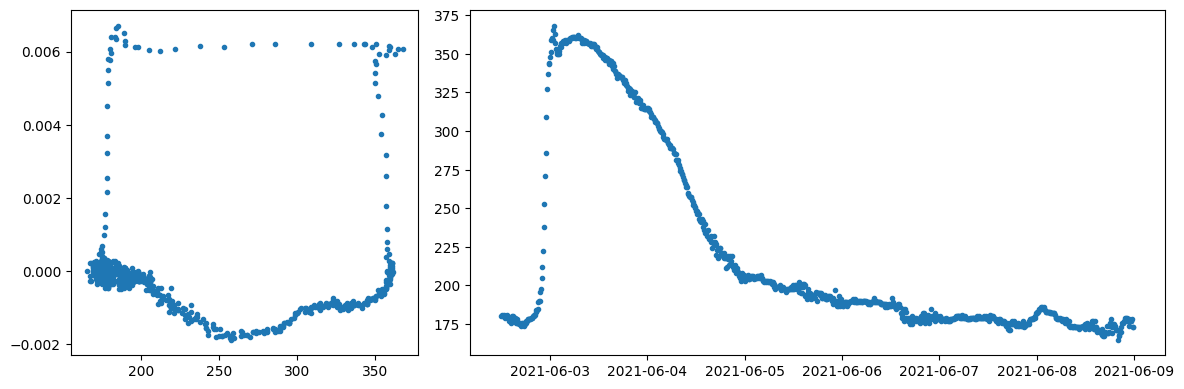

In [9]:
subset = df["2021-06-02 12:00:00+00:00": "2021-06-09 00:00:00+00:00"]
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2]})
ax[0].scatter(subset['Value'], subset['mean diff'], marker='.')
ax[1].scatter(subset.index, subset['Value'], marker='.')
plt.tight_layout()

In [12]:
subset["date"] = subset.index
subset.head()

/var/folders/rh/hgz2vvm17rqb8qqf31l58v2c0000gn/T/ipykernel_27498/293362054.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,Value,smoothed,time diff,mean diff,date
date,,,,,,
2021-06-02 12:01:00+00:00,2021-06-02 12:01:00+00:00,180.0,179.125000,600.0,-0.000104,2021-06-02 12:01:00+00:00
2021-06-02 12:11:00+00:00,2021-06-02 12:11:00+00:00,181.0,179.062500,600.0,-0.000104,2021-06-02 12:11:00+00:00
2021-06-02 12:21:00+00:00,2021-06-02 12:21:00+00:00,180.0,178.979167,600.0,-0.000139,2021-06-02 12:21:00+00:00
2021-06-02 12:31:00+00:00,2021-06-02 12:31:00+00:00,180.0,178.895833,600.0,-0.000139,2021-06-02 12:31:00+00:00
2021-06-02 12:41:00+00:00,2021-06-02 12:41:00+00:00,181.0,178.833333,600.0,-0.000104,2021-06-02 12:41:00+00:00


In [14]:
times = subset["date"]
values = subset["Value"]
diffs = subset["mean diff"]

# Create subplots
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Hydrograph Time Series", "Hydrograph Dynamics"), horizontal_spacing=0.02)

# Add background data points
fig.add_trace(
    go.Scatter(x=times, y=values, mode='markers', marker=dict(color='lightblue', size=5)),
    row=1, col=1
)

# Add histogram to the second subplot
fig.add_trace(
    go.Scatter(x=diffs, y=values, mode='markers', marker=dict(color='lightgray', size=5)),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=[times[0]], y=[values[0]], mode='markers', marker=dict(color='blue', size=12)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[diffs[0]], y=[values[0]], mode='markers', marker=dict(color='blue', size=12)),
    row=1, col=2
)

# Create frames for the animation in the first subplot
frames = [
    go.Frame(
        data=[
            go.Scatter(x=[times[k]], y=[values[k]], mode='markers', marker=dict(color="blue", size=12)),  # Update for first subplot
            go.Scatter(x=[diffs[k]], y=[values[k]], mode='markers', marker=dict(color="blue", size=12))   # Update for second subplot
        ],
        traces=[2, 3], 
    )
    for k in range(len(times))
]

fig.frames = frames


fig.update_layout(
    height=600,
    width=800,
    showlegend=False,
    yaxis_title="Water Depth (mm)",
    xaxis_title="Time",  # Setting x-axis label for the first subplot
    xaxis2_title="Change in Water Depth (mm/hr)",  # Setting x-axis label for the second subplot
    xaxis_showgrid=False,  # Remove gridlines for x-axis of the first subplot
    xaxis2_showgrid=False,  # Remove gridlines for x-axis of the second subplot
    yaxis_showgrid=False,  # Remove gridlines for y-axis (shared by both subplots)
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white',
    yaxis_range=[min(values)-20, max(values)+20],  # Fixing the y-axis range
    xaxis_range=[min(times), max(times)],  # Fixing the x-axis range for subplot 1
    xaxis2_range=[min(diffs)-0.001, max(diffs)+0.001],  #
)

# Add play and pause buttons
fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 25, 'easing': 'cubic-in-out'}}], 'label': 'Play', 'method': 'animate'},
                {'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}], 'label': 'Pause', 'method': 'animate'}
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]
)

# Show the figure
fig.show()
fig.write_html('clean_data_animation.html', include_plotlyjs=True)


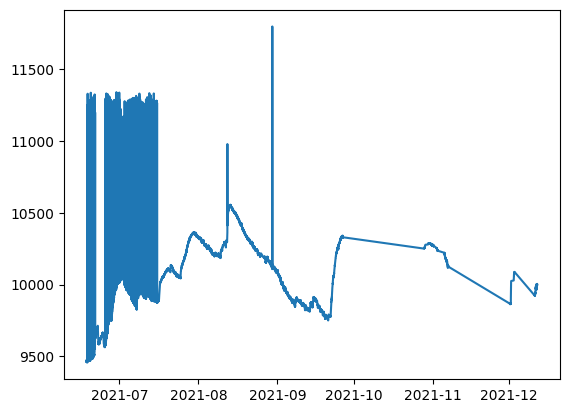

In [15]:
df2 = pd.read_csv('015A_ARB013.csv')
df2['date'] = pd.to_datetime(df2['Unnamed: 0'])
df2.set_index('date', inplace=True)
df2, df2_down, df2_up = take_derivative(df2)
plt.plot(df2.index, df2['Value'])

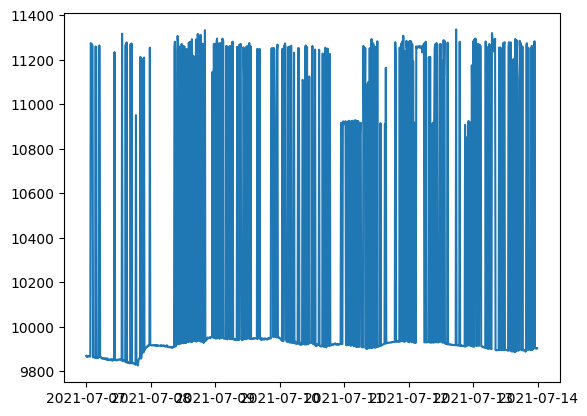

In [17]:
subset2 = df2["2021-07-07 00:00:00+00:00": "2021-07-14 00:00:00+00:00"]
plt.plot(subset2.index, subset2['Value'])

In [19]:
subset2["date"] = subset2.index

/var/folders/rh/hgz2vvm17rqb8qqf31l58v2c0000gn/T/ipykernel_27498/3078123789.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
times = subset2["date"]
values = subset2["Value"]
diffs = subset2["mean diff"]

# Create subplots
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Noisy Hydrograph Time Series", "Noisy Hydrograph Dynamics"), horizontal_spacing=0.02)

# Add background data points
fig.add_trace(
    go.Scatter(x=times, y=values, mode='markers', marker=dict(color='lightblue', size=5)),
    row=1, col=1
)

# Add histogram to the second subplot
fig.add_trace(
    go.Scatter(x=diffs, y=values, mode='markers', marker=dict(color='lightgray', size=5)),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=[times[0]], y=[values[0]], mode='markers', marker=dict(color='blue', size=12)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[diffs[0]], y=[values[0]], mode='markers', marker=dict(color='blue', size=12)),
    row=1, col=2
)

# Create frames for the animation in the first subplot
frames = [
    go.Frame(
        data=[
            go.Scatter(x=[times[k]], y=[values[k]], mode='markers', marker=dict(color="blue", size=12)),  # Update for first subplot
            go.Scatter(x=[diffs[k]], y=[values[k]], mode='markers', marker=dict(color="blue", size=12))   # Update for second subplot
        ],
        traces=[2, 3], 
    )
    for k in range(len(times))
]

fig.frames = frames


fig.update_layout(
    height=600,
    width=800,
    showlegend=False,
    yaxis_title="Water Depth (mm)",
    xaxis_title="Time",  # Setting x-axis label for the first subplot
    xaxis2_title="Change in Water Depth (mm/hr)",  # Setting x-axis label for the second subplot
    xaxis_showgrid=False,  # Remove gridlines for x-axis of the first subplot
    xaxis2_showgrid=False,  # Remove gridlines for x-axis of the second subplot
    yaxis_showgrid=False,  # Remove gridlines for y-axis (shared by both subplots)
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white',
    yaxis_range=[min(values)-20, max(values)+20],  # Fixing the y-axis range
    xaxis_range=[min(times), max(times)],  # Fixing the x-axis range for subplot 1
    xaxis2_range=[min(diffs)-0.001, max(diffs)+0.001],  #
)

# Add play and pause buttons
fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 25, 'easing': 'cubic-in-out'}}], 'label': 'Play', 'method': 'animate'},
                {'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}], 'label': 'Pause', 'method': 'animate'}
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]
)

# Show the figure
fig.show()
fig.write_html('noisy_data_animation.html', include_plotlyjs=True)

In [21]:
def grab_csv(file): 
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['Unnamed: 0'])
    df.set_index('date', inplace=True)
    return df

plots = [
    {'filename': '015A_ARB013.csv', 'hover': 'The sensor is obstructed by a bridge.', 'color': 'orange', 'window': ["2021-06-25 00:00:00+00:00","2021-07-05 00:00:00+00:00"]},
    {'filename': '009A_ARB015.csv', 'hover': 'Clean data', 'color': '#0acf00', 'window': ["2021-04-05 00:00:00+00:00","2021-04-20 00:00:00+00:00"] },
    {'filename': '004A_PTK016.csv', 'hover': 'The sensor is tracking two moving variables.', 'color': 'orange', 'window': ["2022-03-25 00:00:00+00:00","2022-06-05 00:00:00+00:00"]},
    {'filename': '031A_MDOT488.csv', 'hover': 'Clean data', 'color': '#0acf00', 'window': ["2022-08-20 00:00:00+00:00","2022-08-30 00:00:00+00:00"]},
    {'filename': '107A_MDOT1500.csv', 'hover': 'Clean data', 'color': '#0acf00', 'window': ["2022-07-20 00:00:00+00:00","2022-08-15 00:00:00+00:00"]},
    {'filename': '010A_PTK017.csv', 'hover': 'This sensor is obstructed by plants growing out of the water.', 'color': 'orange', 'window': ["2021-07-20 00:00:00+00:00","2021-08-15 00:00:00+00:00"]},
    {'filename': '068A_MDOT6142.csv', 'hover': 'Clean data', 'color': '#0acf00', 'window': ["2022-08-06 00:00:00+00:00","2022-08-25 00:00:00+00:00"]},
    {'filename': '067A_PTK018.csv', 'hover': 'This sensor is almost completely obstructed.', 'color': 'orange', 'window': ["2022-08-06 00:00:00+00:00","2022-08-25 00:00:00+00:00"]}, 
    {'filename': '056A_DET008.csv', 'hover': 'Clean data', 'color': '#0acf00', 'window': ["2022-08-06 00:00:00+00:00","2022-08-25 00:00:00+00:00"]},
]

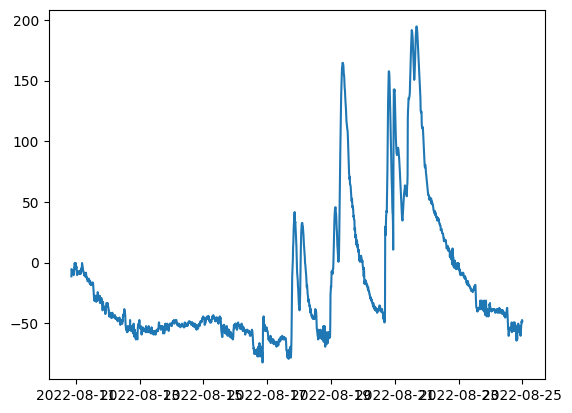

In [22]:
test = grab_csv('056A_DET008.csv')
test = test["2022-08-06 00:00:00+00:00":"2022-08-25 00:00:00+00:00"]
plt.plot(test.index, test['Value'])

In [23]:
# Create a 3x3 subplot layout
fig = make_subplots(rows=3, cols=3)

# Loop through each subplot position
for i in range(1, 4):  # Rows
    for j in range(1, 4):  # Columns
        site= plots[3*(i-1)+j-1]
        data = grab_csv(site['filename'])
        data = data[site['window'][0]:site['window'][1]]
        fig.add_trace(
            go.Scatter(x=data.index, y=data['Value'],
                       hoverinfo='text', text=site['hover'], marker=dict(color=site['color'], size=1)),
            row=i, col=j
        )

# Update layout and hovermode
fig.update_layout(height=750, width=800, hovermode='closest', showlegend=False, title_text="Clean and noisy data from a hydrologic sensor network",
                  plot_bgcolor='#f0f0f0',  # Set plot background color to white
    )
fig.update_traces(mode='markers+lines')  # Adding markers to make hover more noticeable

# Show figure
fig.show()
fig.write_html('sensor_network_data.html', include_plotlyjs=True)